In [1]:
plt = plotter()
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
import jax
import jax.numpy as np
import numpy as np0

In [3]:
import valjax.endy as vj
import valjax.tools as vt

## Optimize

In [4]:
spec = vt.Spec('log')

In [5]:
def f(α, x):
    return np.log(x) - x/α
def fx(α, y):
    x = spec.decode(y)
    return f(α, x)
dfx = jax.grad(fx, argnums=1)
ddfx = jax.grad(dfx, argnums=1)

In [6]:
def opt(α, x0, clip=2.0, K=5):
    dobj1 = jax.partial(dfx, α)
    ddobj1 = jax.partial(ddfx, α)
    y0 = spec.encode(x0)
    y1 = vj.optim_newton(dobj1, ddobj1, y0, clip=clip, K=K)
    x1 = spec.decode(y1)
    return x1
dopt = jax.grad(opt)

In [7]:
jf = jax.jit(f)
jfx = jax.jit(fx)
jopt = jax.jit(opt)
jdopt = jax.jit(dopt)

In [8]:
opt(1.5, 0.5) # = α

DeviceArray(1.5000005, dtype=float32)

In [9]:
jdopt(1.5, 0.5) # = 1

DeviceArray(1.000012, dtype=float32)

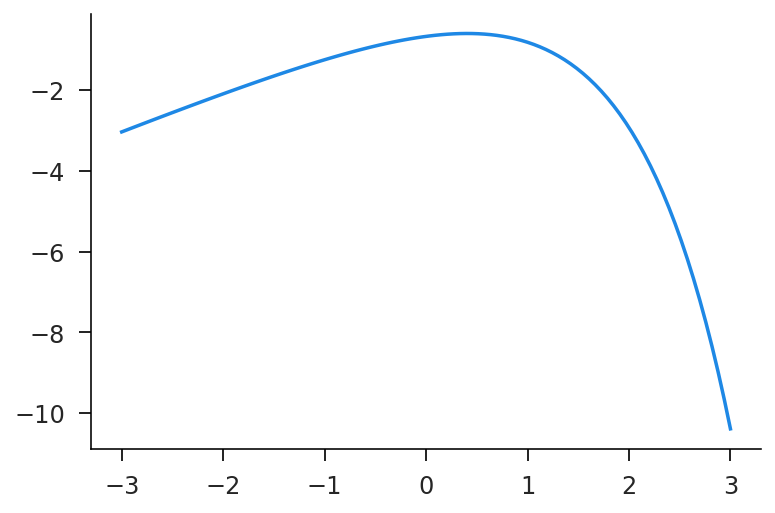

In [10]:
x = np.linspace(-3.0, 3.0, 100)
plt.plot(x, jfx(1.5, x));

## Interpolation

In [11]:
x = np.linspace(0, 1, 101)
y = x*(1-x)

In [12]:
def dummy_interp(x1):
    return vj.interp(x, y, x1)
d_dummy_interp = jax.grad(dummy_interp)
dv_dummy_interp = jax.vmap(d_dummy_interp)

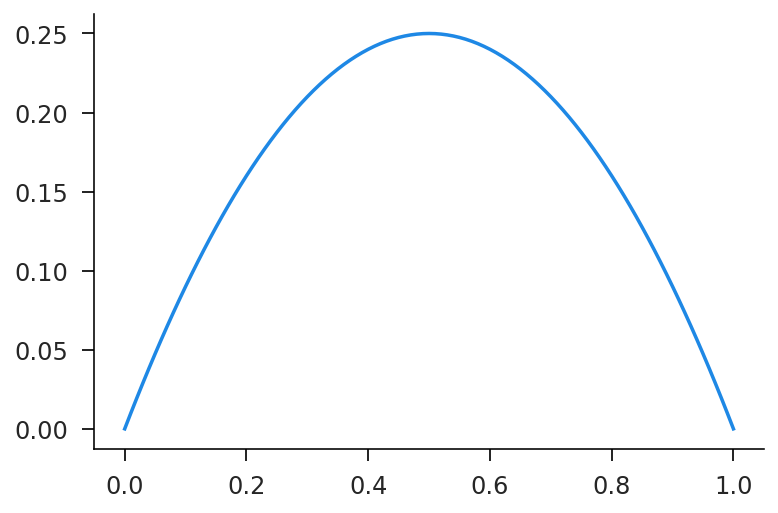

In [13]:
y1 = dummy_interp(x)
plt.plot(x, y1);

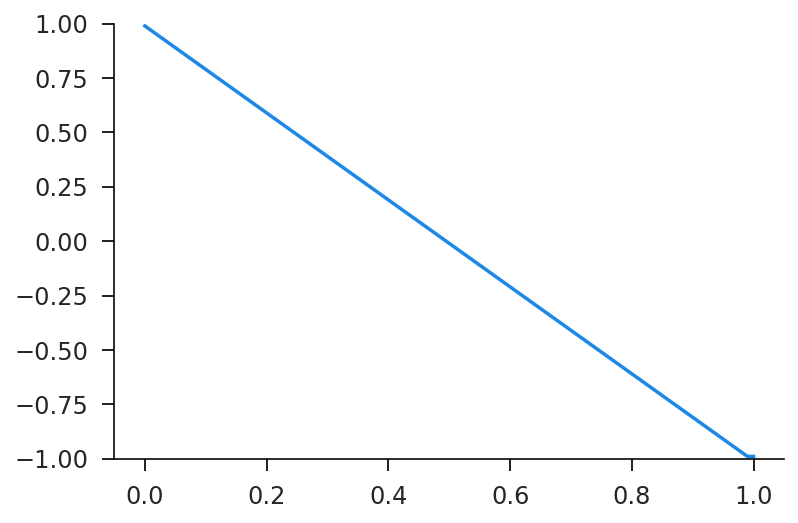

In [14]:
dy1 = dv_dummy_interp(x)
plt.plot(x, dy1);
plt.ylim(-1, 1);

## Grid Optimize

In [15]:
N = 10000
s_grid = np.linspace(0, 1, N)

In [16]:
def obj(s, c):
    return -(s-c)**2

In [17]:
def tot(c):
    return np.sum(obj(s_grid, c))

In [18]:
dtot = jax.grad(tot)

In [19]:
jtot = jax.jit(tot)
jdtot = jax.jit(dtot)

In [20]:
K = 250
speed = 0.01

In [21]:
c = 0.5*np.ones(N)
hist = np0.zeros(K)
for i in range(K):
    hist[i] = jtot(c)
    dc = jdtot(c)
    c += speed*dc

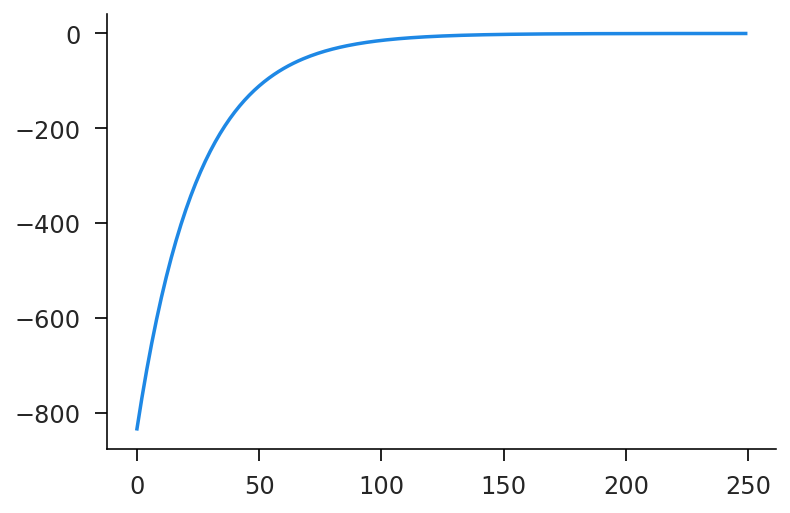

In [22]:
plt.plot(hist);

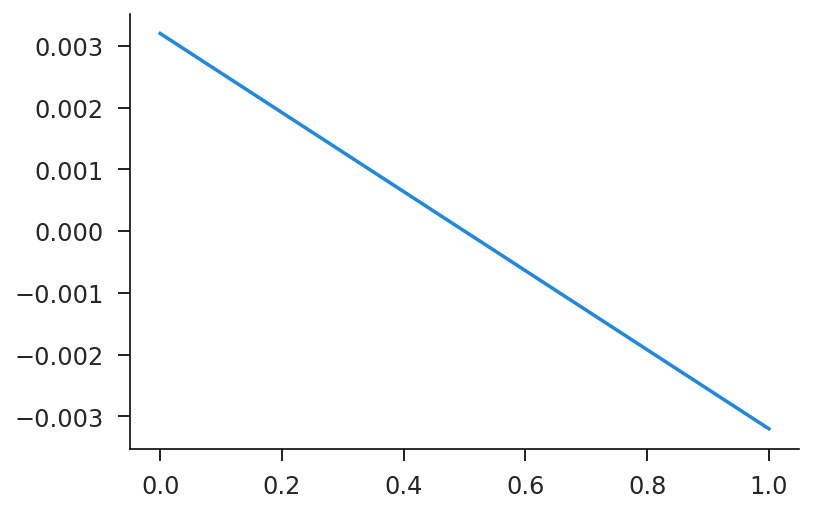

In [23]:
plt.plot(s_grid, c - s_grid);